This notebook includes code examples for comaraing the synthetic ddata of offsprimg GAN with Real Data. We also test the same for PPO-GAN. To evaluate the improvement from PG-cGAN synthetic data form PG-cGAN is also put throught the same tests. 
 

# All Imports

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, Sequential, Model, optimizers, losses
from tensorflow.keras.utils import to_categorical

import os
import glob
import argparse
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
# import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

import cv2
# from Computer_Vision.Sobel_Edge_Detection.convolution import convolution
# from Computer_Vision.Sobel_Edge_Detection.gaussian_smoothing import gaussian_blur

import time
# import PIL
# import imageio
# import pickle
from IPython import display

from sklearn.decomposition import PCA 
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.mixture import GaussianMixture
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
 

print('\n',
      tf.__version__,'\n',
      np.__version__,'\n',
      pd.__version__)


 2.8.0 
 1.21.6 
 1.3.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Real
X_train = np.load("/content/drive/MyDrive/X_Shi_Lab/Data_HLA/X_train.npy")
Y_train = np.load("/content/drive/MyDrive/X_Shi_Lab/Data_HLA/Y_train.npy")

In [ ]:
# Real in nice order #usualy D means (X and Y stacked )
D_real_EAS = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_EAS.npy')
D_real_AMR = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_AMR.npy')
D_real_EUR = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_EUR.npy')
D_real_AFR = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_AFR.npy')
D_real_SAS = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/D_real_SAS.npy')
D_real = np.vstack((D_real_EAS,D_real_AMR,D_real_EUR,D_real_AFR,D_real_SAS))


In [ ]:
##Syn in front of D or X or Y means its synthetic 
#ss after D means it has been passed through F_1-generator
SynDss_SAGAN1_m0t6c12 = np.load('/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/SyntheticData/m0t6c12/SynDss_SAGAN1_m0t6c12.npy') 
# SynDss_PPO_m0t1c34 = np.load('/content/drive/MyDrive/X_Shi_Lab/SemX/PPOGAN/SyntheticData/SynDss_PPO_m0t1c34.npy') 

In [ ]:
SynX_PGcB_m0t1c34 = np.load('/content/drive/MyDrive/X_Shi_Lab/SemX/PGcB/SyntheticData/m0t1c34/SynX_PGcB_m0t1c34.npy') 
SynY_PGcB_m0t1c34 = np.load('/content/drive/MyDrive/X_Shi_Lab/SemX/PGcB/SyntheticData/m0t1c34/SynY_PGcB_m0t1c34.npy') 

### Bringing SynD to same order as of D_real

This allows Plotly to automatically use same colour for a population for all 4 plots, otherwise this step is unnecessary. 

In [ ]:
SynD_PGcB_m0t1c34 = np.hstack((SynX_PGcB_m0t1c34,SynY_PGcB_m0t1c34)) 

D_columns = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
D_columns = D_columns.tolist()
SynD_PGcB_m0t1c34 = pd.DataFrame(SynD_PGcB_m0t1c34, columns=D_columns)
SynD_PGcB_m0t1c34["GAN SYN Label"]=SynD_PGcB_m0t1c34["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})

In [ ]:

SynX_PGcB_m0t1c34_EAS = np.empty(shape=(0,7160))
SynY_PGcB_m0t1c34_EAS = np.empty(shape=(0,1))
SynX_PGcB_m0t1c34_AMR = np.empty(shape=(0,7160))
SynY_PGcB_m0t1c34_AMR = np.empty(shape=(0,1))
SynX_PGcB_m0t1c34_EUR = np.empty(shape=(0,7160))
SynY_PGcB_m0t1c34_EUR = np.empty(shape=(0,1))
SynX_PGcB_m0t1c34_AFR = np.empty(shape=(0,7160))
SynY_PGcB_m0t1c34_AFR = np.empty(shape=(0,1))
SynX_PGcB_m0t1c34_SAS = np.empty(shape=(0,7160))
SynY_PGcB_m0t1c34_SAS = np.empty(shape=(0,1))

for i in range (SynX_PGcB_m0t1c34.shape[0]):
  if SynD_PGcB_m0t1c34.iloc[i][7160]== 'EAS':
    SynX_PGcB_m0t1c34_EAS= np.vstack((SynX_PGcB_m0t1c34_EAS,SynX_PGcB_m0t1c34[i]))
    SynY_PGcB_m0t1c34_EAS= np.vstack((SynY_PGcB_m0t1c34_EAS,SynY_PGcB_m0t1c34[i])) 
  if SynD_PGcB_m0t1c34.iloc[i][7160]== 'AMR':
    SynX_PGcB_m0t1c34_AMR= np.vstack((SynX_PGcB_m0t1c34_AMR,SynX_PGcB_m0t1c34[i]))
    SynY_PGcB_m0t1c34_AMR= np.vstack((SynY_PGcB_m0t1c34_AMR,SynY_PGcB_m0t1c34[i]))
  if SynD_PGcB_m0t1c34.iloc[i][7160]== 'EUR':
    SynX_PGcB_m0t1c34_EUR= np.vstack((SynX_PGcB_m0t1c34_EUR,SynX_PGcB_m0t1c34[i]))
    SynY_PGcB_m0t1c34_EUR= np.vstack((SynY_PGcB_m0t1c34_EUR,SynY_PGcB_m0t1c34[i]))
  if SynD_PGcB_m0t1c34.iloc[i][7160]== 'AFR':
    SynX_PGcB_m0t1c34_AFR= np.vstack((SynX_PGcB_m0t1c34_AFR,SynX_PGcB_m0t1c34[i]))
    SynY_PGcB_m0t1c34_AFR= np.vstack((SynY_PGcB_m0t1c34_AFR,SynY_PGcB_m0t1c34[i]))
  if SynD_PGcB_m0t1c34.iloc[i][7160]== 'SAS':
    SynX_PGcB_m0t1c34_SAS= np.vstack((SynX_PGcB_m0t1c34_SAS,SynX_PGcB_m0t1c34[i]))
    SynY_PGcB_m0t1c34_SAS= np.vstack((SynY_PGcB_m0t1c34_SAS,SynY_PGcB_m0t1c34[i]))


# all of these are not one hot encoded yet 

SynD_PGcB_m0t1c34_EAS = np.hstack((SynX_PGcB_m0t1c34_EAS,SynY_PGcB_m0t1c34_EAS))
SynD_PGcB_m0t1c34_AMR = np.hstack((SynX_PGcB_m0t1c34_AMR,SynY_PGcB_m0t1c34_AMR))
SynD_PGcB_m0t1c34_EUR = np.hstack((SynX_PGcB_m0t1c34_EUR,SynY_PGcB_m0t1c34_EUR))
SynD_PGcB_m0t1c34_AFR = np.hstack((SynX_PGcB_m0t1c34_AFR,SynY_PGcB_m0t1c34_AFR))
SynD_PGcB_m0t1c34_SAS = np.hstack((SynX_PGcB_m0t1c34_SAS,SynY_PGcB_m0t1c34_SAS))


In [ ]:
SynD_PGcB_m0t1c34 = np.vstack((SynD_PGcB_m0t1c34_EAS,SynD_PGcB_m0t1c34_AMR,SynD_PGcB_m0t1c34_EUR,SynD_PGcB_m0t1c34_AFR,SynD_PGcB_m0t1c34_SAS))

# Pearson Corellation Coefficient 

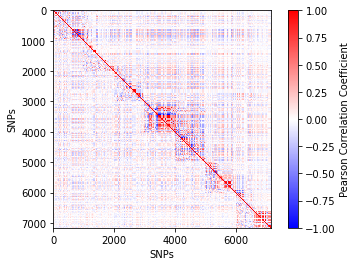

In [ ]:
SynXss_SAGAN1_m0t6c12 = pd.DataFrame(SynXss_SAGAN1_m0t6c12)
SynXss_SAGAN1_m0t6c12 = SynDss_SAGAN1_m0t6c12.iloc[:,0:7160]
#Corr of synthetic
SynXss_SAGAN1_m0t6c12_corr=SynXss_SAGAN1_m0t6c12.corr(method='pearson')
np.save("SynXss_SAGAN1_m0t6c12_corr",SynXss_SAGAN1_m0t6c12_corr)
!mkdir /content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t12
!cp SynXss_SAGAN1_m0t6c12_corr.npy /content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t12/
# SynXss_SAGAN1_m0t6c12_corr = np.load("/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t12/SynXss_SAGAN1_m0t6c12_corr.npy")
SynXss_SAGAN1_m0t6c12_corr_positive = np.abs(SynXss_SAGAN1_m0t6c12_corr)
#Corr of real
D_real_corr = np.load("/content/drive/MyDrive/X_Shi_Lab/Data_HLA/df_real_corr.npy")
#comparison
Corr_comp = np.triu(D_real_corr, k=1) + np.tril(SynXss_SAGAN1_m0t6c12_corr, k=0)

SynXss_SAGAN1_m0t6c12_corr = np.load("/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t12/SynXss_SAGAN1_m0t6c12_corr.npy")
D_real_corr = np.load("/content/drive/MyDrive/X_Shi_Lab/Data_HLA/df_real_corr.npy")
Corr_comp = np.triu(D_real_corr, k=1) + np.tril(SynXss_SAGAN1_m0t6c12_corr, k=0)

fig, ax = plt.subplots()
  
# show image
shw = ax.imshow(Corr_comp, cmap="bwr", interpolation='none')
  
# make bar
bar = plt.colorbar(shw, cmap="bwr")
  
# show plot with labels
plt.xlabel('SNPs')
plt.ylabel('SNPs')
bar.set_label('Pearson Correlation Coefficient')
plt.show()

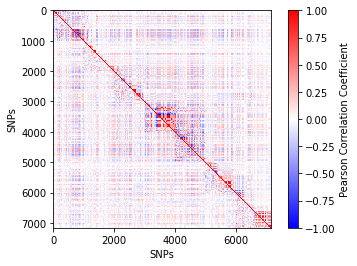

In [ ]:
# SynDss_PPO_m0t1c34 = pd.DataFrame(SynDss_PPO_m0t1c34)
# SynXss_PPO_m0t1c34 = SynDss_PPO_m0t1c34.iloc[:,0:7160]
# #Corr of synthetic
# SynXss_PPO_m0t1c34_corr=SynXss_PPO_m0t1c34.corr(method='pearson')
# np.save("SynXss_PPO_m0t1c34_corr",SynXss_PPO_m0t1c34_corr)
# !mkdir /content/drive/MyDrive/X_Shi_Lab/SemX/PPOGAN/SyntheticData
# !cp SynXss_PPO_m0t1c34_corr.npy /content/drive/MyDrive/X_Shi_Lab/SemX/PPOGAN/SyntheticData
SynXss_PPO_m0t1c34_corr = np.load("/content/drive/MyDrive/X_Shi_Lab/SemX/PPOGAN//SyntheticData/SynXss_PPO_m0t1c34_corr.npy")
# SynXss_PPO_m0t1c34_corr_positive = np.abs(SynXss_PPO_m0t1c34_corr)
#Corr of real
D_real_corr = np.load("/content/drive/MyDrive/X_Shi_Lab/Data_HLA/df_real_corr.npy")
#comparison
Corr_comp = np.triu(D_real_corr, k=1) + np.tril(SynXss_PPO_m0t1c34_corr, k=0)

fig, ax = plt.subplots()  
# show image
shw = ax.imshow(Corr_comp, cmap="bwr", interpolation='none')
  
# make bar
bar = plt.colorbar(shw, cmap="bwr")
  
# show plot with labels
plt.xlabel('SNPs')
plt.ylabel('SNPs')
bar.set_label('Pearson Correlation Coefficient')
plt.show()

mkdir: cannot create directory ‘/content/drive/MyDrive/X_Shi_Lab/SemX/PGcB/SyntheticData’: File exists


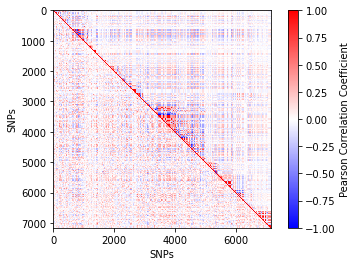

In [ ]:
SynD_PGcB_m0t1c34 = pd.DataFrame(SynD_PGcB_m0t1c34)
SynX_PGcB_m0t1c34 = SynD_PGcB_m0t1c34.iloc[:,0:7160]
#Corr of synthetic
SynX_PGcB_m0t1c34_corr=SynX_PGcB_m0t1c34.corr(method='pearson')
np.save("SynX_PGcB_m0t1c34_corr",SynX_PGcB_m0t1c34_corr)
!mkdir /content/drive/MyDrive/X_Shi_Lab/SemX/PGcB/SyntheticData
!cp SynX_PGcB_m0t1c34_corr.npy /content/drive/MyDrive/X_Shi_Lab/SemX/PGcB/SyntheticData
# SynX_PGcB_m0t1c34_corr = np.load("/content/drive/MyDrive/X_Shi_Lab/SemX/PGcB/SyntheticData/SynX_PGcB_m0t1c34_corr.npy")
SynX_PGcB_m0t1c34_corr_positive = np.abs(SynX_PGcB_m0t1c34_corr)
#Corr of real
D_real_corr = np.load("/content/drive/MyDrive/X_Shi_Lab/Data_HLA/df_real_corr.npy")
#comparison
Corr_comp = np.triu(D_real_corr, k=1) + np.tril(SynX_PGcB_m0t1c34_corr, k=0)

fig, ax = plt.subplots()
  
# show image
shw = ax.imshow(Corr_comp, cmap="bwr", interpolation='none')
  
# make bar
bar = plt.colorbar(shw, cmap="bwr")
  
# show plot with labels
plt.xlabel('SNPs')
plt.ylabel('SNPs')
bar.set_label('Pearson Correlation Coefficient')
plt.show()

# PCA

HTML files for these PCA plots are made available attached in a separate folder. One can zoom in/zoom out hide/undide samples  of a population to visualize the overlapping regeions better. 

### Real Data

In [ ]:
column = np.load ('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
column = column.tolist()

D_real = pd.DataFrame(D_real, columns=column)
D_real["GAN SYN Label"]=D_real["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})

df = D_real.drop('GAN SYN Label', axis= 1)
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() 

fig = px.scatter_matrix(
    components,
    color=D_real["GAN SYN Label"],
    dimensions=range(n_components),
    labels=D_real["GAN SYN Label"],
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t12/D_real.html')

## Offspring GAN

In [ ]:
column = np.load ('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
column = column.tolist()

SynDss_PPO_m0t1c34 = pd.DataFrame(SynDss_PPO_m0t1c34, columns=column)
SynDss_PPO_m0t1c34["GAN SYN Label"]=SynDss_PPO_m0t1c34["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})

df = SynDss_PPO_m0t1c34.drop('GAN SYN Label', axis= 1)
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() 

fig = px.scatter_matrix(
    components,
    color=SynDss_PPO_m0t1c34["GAN SYN Label"],
    dimensions=range(n_components),
    labels=SynDss_PPO_m0t1c34["GAN SYN Label"],
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/PPOGAN/SyntheticData/SynDss_PPO_m0t1c34.html')

In [ ]:
column = np.load ('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
column = column.tolist()

SynDss_SAGAN1_m0t6c12 = pd.DataFrame(SynDss_SAGAN1_m0t6c12, columns=column)
SynDss_SAGAN1_m0t6c12["GAN SYN Label"]=SynDss_SAGAN1_m0t6c12["GAN SYN Label"].replace({   
    0: 'SynEAS',
    1 : 'SynAMR',
    2 : 'SynEUR',
    3 : 'SynAFR',
    4 : 'SynSAS'})

D_real = pd.DataFrame(D_real, columns=column)
D_real["GAN SYN Label"]=D_real["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})

D_SynDss_real = pd.concat([SynDss_SAGAN1_m0t6c12,D_real],ignore_index=True)

df = D_SynDss_real.drop('GAN SYN Label', axis= 1)
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() 

fig = px.scatter_matrix(
    components,
    color=D_SynDss_real["GAN SYN Label"],
    dimensions=range(n_components),
    labels=D_SynDss_real["GAN SYN Label"],
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t12/SynDss_vs_D_real.html')

## PPO GAN

In [ ]:
column = np.load ('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
column = column.tolist()

SynDss_PPO_m0t1c34 = pd.DataFrame(SynDss_PPO_m0t1c34, columns=column)
SynDss_PPO_m0t1c34["GAN SYN Label"]=SynDss_PPO_m0t1c34["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})

df = SynDss_PPO_m0t1c34.drop('GAN SYN Label', axis= 1)
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() 

fig = px.scatter_matrix(
    components,
    color=SynDss_PPO_m0t1c34["GAN SYN Label"],
    dimensions=range(n_components),
    labels=SynDss_PPO_m0t1c34["GAN SYN Label"],
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/PPOGAN/SyntheticData/SynDss_PPO_m0t1c34.html')

In [ ]:
column = np.load ('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
column = column.tolist()

SynDss_PPO_m0t1c34 = pd.DataFrame(SynDss_PPO_m0t1c34, columns=column)
SynDss_PPO_m0t1c34["GAN SYN Label"]=SynDss_PPO_m0t1c34["GAN SYN Label"].replace({   
    0: 'SynEAS',
    1 : 'SynAMR',
    2 : 'SynEUR',
    3 : 'SynAFR',
    4 : 'SynSAS'})

D_real = pd.DataFrame(D_real, columns=column)
D_real["GAN SYN Label"]=D_real["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})

D_SynDss_real = pd.concat([SynDss_PPO_m0t1c34,D_real],ignore_index=True)

df = D_SynDss_real.drop('GAN SYN Label', axis= 1)
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() 

fig = px.scatter_matrix(
    components,
    color=D_SynDss_real["GAN SYN Label"],
    dimensions=range(n_components),
    labels=D_SynDss_real["GAN SYN Label"],
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/PPOGAN/SyntheticData/SynDss_vs_D_real.html')

## PGcGAN

In [ ]:
column = np.load ('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
column = column.tolist()
 
SynD_PGcB_m0t1c34 = pd.DataFrame(SynD_PGcB_m0t1c34, columns=column)
SynD_PGcB_m0t1c34["GAN SYN Label"]=SynD_PGcB_m0t1c34["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})

df = SynD_PGcB_m0t1c34.drop('GAN SYN Label', axis= 1)
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() 

fig = px.scatter_matrix(
    components,
    color=SynD_PGcB_m0t1c34["GAN SYN Label"],
    dimensions=range(n_components),
    labels=SynD_PGcB_m0t1c34["GAN SYN Label"],
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/PGcB/SyntheticData/SynD_PGcB_m0t1c34.html')

In [ ]:
SynD_PGcB_m0t1c34 = np.vstack((SynD_PGcB_m0t1c34_EAS,SynD_PGcB_m0t1c34_AMR,SynD_PGcB_m0t1c34_EUR,SynD_PGcB_m0t1c34_AFR,SynD_PGcB_m0t1c34_SAS))

In [ ]:
column = np.load ('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
column = column.tolist()

SynD_PGcB_m0t1c34 = pd.DataFrame(SynD_PGcB_m0t1c34, columns=column)
SynD_PGcB_m0t1c34["GAN SYN Label"]=SynD_PGcB_m0t1c34["GAN SYN Label"].replace({   
    0: 'SynEAS',
    1 : 'SynAMR',
    2 : 'SynEUR',
    3 : 'SynAFR',
    4 : 'SynSAS'})

D_real = pd.DataFrame(D_real, columns=column)
D_real["GAN SYN Label"]=D_real["GAN SYN Label"].replace({   
    0: 'EAS',
    1 : 'AMR',
    2 : 'EUR',
    3 : 'AFR',
    4 : 'SAS'})

D_SynD_real = pd.concat([SynD_PGcB_m0t1c34,D_real],ignore_index=True)

df = D_SynD_real.drop('GAN SYN Label', axis= 1)
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() 

fig = px.scatter_matrix(
    components,
    color=D_SynD_real["GAN SYN Label"],
    dimensions=range(n_components),
    labels=D_SynD_real["GAN SYN Label"],
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/PGcB/SyntheticData/SynD_control_vs_D_real.html')

In [ ]:
#'''  Try this if you think the dataset is too big and points overlap with each other a lot.  '''
# SynDss_SAGAN1_m0t6c12_a, SynDss_SAGAN1_m0t6c12_b = train_test_split(SynDss_SAGAN1_m0t6c12, test_size=0.7506)

# SynXss_SAGAN1_m0t6c12_a = SynDss_SAGAN1_m0t6c12_a[:,0:7160]
# SynYss_SAGAN1_m0t6c12_a = SynDss_SAGAN1_m0t6c12_a[:,-1]
# D_columns = np.load('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
# D_columns = D_columns.tolist()
# SynDss_SAGAN1_m0t6c12_a = pd.DataFrame(SynDss_SAGAN1_m0t6c12_a, columns=D_columns)
# SynDss_SAGAN1_m0t6c12_a["GAN SYN Label"]=SynDss_SAGAN1_m0t6c12_a["GAN SYN Label"].replace({   
#     0.0: 'EAS',
#     1.0 : 'AMR',
#     2.0 : 'EUR',
#     3.0 : 'AFR',
#     4.0 : 'SAS'})
# SynXss_SAGAN1_m0t6c12_a_EAS = np.empty(shape=(0,7160))
# SynYss_SAGAN1_m0t6c12_a_EAS = np.empty(shape=(0,1))
# SynXss_SAGAN1_m0t6c12_a_AMR = np.empty(shape=(0,7160))
# SynYss_SAGAN1_m0t6c12_a_AMR = np.empty(shape=(0,1))
# SynXss_SAGAN1_m0t6c12_a_EUR = np.empty(shape=(0,7160))
# SynYss_SAGAN1_m0t6c12_a_EUR = np.empty(shape=(0,1))
# SynXss_SAGAN1_m0t6c12_a_AFR = np.empty(shape=(0,7160))
# SynYss_SAGAN1_m0t6c12_a_AFR = np.empty(shape=(0,1))
# SynXss_SAGAN1_m0t6c12_a_SAS = np.empty(shape=(0,7160))
# SynYss_SAGAN1_m0t6c12_a_SAS = np.empty(shape=(0,1))

# for i in range (SynXss_SAGAN1_m0t6c12_a.shape[0]):
#   if SynDss_SAGAN1_m0t6c12_a.iloc[i][7160]== 'EAS':
#     SynXss_SAGAN1_m0t6c12_a_EAS= np.vstack((SynXss_SAGAN1_m0t6c12_a_EAS,SynXss_SAGAN1_m0t6c12_a[i]))
#     SynYss_SAGAN1_m0t6c12_a_EAS= np.vstack((SynYss_SAGAN1_m0t6c12_a_EAS,SynYss_SAGAN1_m0t6c12_a[i])) 
#   if SynDss_SAGAN1_m0t6c12_a.iloc[i][7160]== 'AMR':
#     SynXss_SAGAN1_m0t6c12_a_AMR= np.vstack((SynXss_SAGAN1_m0t6c12_a_AMR,SynXss_SAGAN1_m0t6c12_a[i]))
#     SynYss_SAGAN1_m0t6c12_a_AMR= np.vstack((SynYss_SAGAN1_m0t6c12_a_AMR,SynYss_SAGAN1_m0t6c12_a[i]))
#   if SynDss_SAGAN1_m0t6c12_a.iloc[i][7160]== 'EUR':
#     SynXss_SAGAN1_m0t6c12_a_EUR= np.vstack((SynXss_SAGAN1_m0t6c12_a_EUR,SynXss_SAGAN1_m0t6c12_a[i]))
#     SynYss_SAGAN1_m0t6c12_a_EUR= np.vstack((SynYss_SAGAN1_m0t6c12_a_EUR,SynYss_SAGAN1_m0t6c12_a[i]))
#   if SynDss_SAGAN1_m0t6c12_a.iloc[i][7160]== 'AFR':
#     SynXss_SAGAN1_m0t6c12_a_AFR= np.vstack((SynXss_SAGAN1_m0t6c12_a_AFR,SynXss_SAGAN1_m0t6c12_a[i]))
#     SynYss_SAGAN1_m0t6c12_a_AFR= np.vstack((SynYss_SAGAN1_m0t6c12_a_AFR,SynYss_SAGAN1_m0t6c12_a[i]))
#   if SynDss_SAGAN1_m0t6c12_a.iloc[i][7160]== 'SAS':
#     SynXss_SAGAN1_m0t6c12_a_SAS= np.vstack((SynXss_SAGAN1_m0t6c12_a_SAS,SynXss_SAGAN1_m0t6c12_a[i]))
#     SynYss_SAGAN1_m0t6c12_a_SAS= np.vstack((SynYss_SAGAN1_m0t6c12_a_SAS,SynYss_SAGAN1_m0t6c12_a[i]))


# # all of these are not one hot encoded yet 

# SynDss_SAGAN1_m0t6c12_a_EAS = np.hstack((SynXss_SAGAN1_m0t6c12_a_EAS,SynYss_SAGAN1_m0t6c12_a_EAS))
# SynDss_SAGAN1_m0t6c12_a_AMR = np.hstack((SynXss_SAGAN1_m0t6c12_a_AMR,SynYss_SAGAN1_m0t6c12_a_AMR))
# SynDss_SAGAN1_m0t6c12_a_EUR = np.hstack((SynXss_SAGAN1_m0t6c12_a_EUR,SynYss_SAGAN1_m0t6c12_a_EUR))
# SynDss_SAGAN1_m0t6c12_a_AFR = np.hstack((SynXss_SAGAN1_m0t6c12_a_AFR,SynYss_SAGAN1_m0t6c12_a_AFR))
# SynDss_SAGAN1_m0t6c12_a_SAS = np.hstack((SynXss_SAGAN1_m0t6c12_a_SAS,SynYss_SAGAN1_m0t6c12_a_SAS))
# SynDss_SAGAN1_m0t6c12_a = np.vstack((SynDss_SAGAN1_m0t6c12_a_EAS,SynDss_SAGAN1_m0t6c12_a_AMR,SynDss_SAGAN1_m0t6c12_a_EUR,SynDss_SAGAN1_m0t6c12_a_AFR,SynDss_SAGAN1_m0t6c12_a_SAS))
# column = np.load ('/content/drive/MyDrive/X_Shi_Lab/Data_HLA/column.npy')
# column = column.tolist()

# SynDss_SAGAN1_m0t6c12_a = pd.DataFrame(SynDss_SAGAN1_m0t6c12_a, columns=column)
# SynDss_SAGAN1_m0t6c12_a["GAN SYN Label"]=SynDss_SAGAN1_m0t6c12_a["GAN SYN Label"].replace({   
#     0: 'EAS',
#     1 : 'AMR',
#     2 : 'EUR',
#     3 : 'AFR',
#     4 : 'SAS'})

# df = SynDss_SAGAN1_m0t6c12_a.drop('GAN SYN Label', axis= 1)
# n_components = 3
# pca = PCA(n_components=n_components)
# components = pca.fit_transform(df)
# total_var = pca.explained_variance_ratio_.sum() 

# fig = px.scatter_matrix(
#     components,
#     color=SynDss_SAGAN1_m0t6c12_a["GAN SYN Label"],
#     dimensions=range(n_components),
#     labels=SynDss_SAGAN1_m0t6c12_a["GAN SYN Label"],
#     title=f'Total Explained Variance: {total_var:.2f}%',
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()
# fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/m0t12/SynDss_SAGAN1_m0t6c12_a.html')

# Minor Allele frequency

In [ ]:
# print(X_train.shape)
count_X= np.sum(X_train, axis=0) # this yeild a matrix of SNP wise Genotype counts in column and SNPs in rows  
MAF_R = (count_X[:,1]+count_X[:,2]+2*count_X[:,3])/(2*(count_X[:,0]+count_X[:,1]+count_X[:,2]+count_X[:,3]))
#i.e. (num of Aa + number of aA + 2* number of aa)/(2*population size)
#for allele_freq >0.5, MAF = 1-allele_freq
for i in range(MAF_R.shape[0]):
  if MAF_R[i] >=0.5:
    MAF_R[i] = 1-MAF_R[i]
MAF_R

array([0.07248402, 0.49261183, 0.09824281, ..., 0.22484025, 0.48003194,
       0.22144568], dtype=float32)

In [ ]:
# print(X_train.shape)
count_X= np.sum(X_train, axis=0) # this yeild a matrix of SNP wise Genotype counts in column and SNPs in rows  
MAF_R = (count_X[:,1]+count_X[:,2]+2*count_X[:,3])/(2*(count_X[:,0]+count_X[:,1]+count_X[:,2]+count_X[:,3]))
#i.e. (num of Aa + number of aA + 2* number of aa)/(2*population size)
#for allele_freq >0.5, MAF = 1-allele_freq
for i in range(MAF_R.shape[0]):
  if MAF_R[i] >=0.5:
    MAF_R[i] = 1-MAF_R[i]
MAF_R

array([0.07248402, 0.49261183, 0.09824281, ..., 0.22484025, 0.48003194,
       0.22144568], dtype=float32)

In [ ]:
SynXss_SAGAN1_m0t6c12 = SynDss_SAGAN1_m0t6c12[:,0:-1]
SynXss_SAGAN1_m0t6c12 = to_categorical(SynXss_SAGAN1_m0t6c12)
X = SynXss_SAGAN1_m0t6c12
# print(X.shape)
count_X= np.sum(SynXss_SAGAN1_m0t6c12, axis=0) # this yeild a matrix of SNP wise Genotype counts in column and SNPs in rows  
MAF_OGAN = (count_X[:,1]+count_X[:,2]+2*count_X[:,3])/(2*(count_X[:,0]+count_X[:,1]+count_X[:,2]+count_X[:,3]))
for i in range(MAF_OGAN.shape[0]):
  if MAF_OGAN[i] >=0.5:
    MAF_OGAN[i] = 1-MAF_OGAN[i]
MAF_OGAN

array([0.15656163, 0.48025528, 0.15476665, ..., 0.24411647, 0.34922218,
       0.22816116], dtype=float32)

In [ ]:
SynXss_SAGAN1_m0t6c12 = SynDss_SAGAN1_m0t6c12[:,0:-1]
SynXss_SAGAN1_m0t6c12 = to_categorical(SynXss_SAGAN1_m0t6c12)
X = SynXss_SAGAN1_m0t6c12
# print(X.shape)
count_X= np.sum(SynXss_SAGAN1_m0t6c12, axis=0) # this yeild a matrix of SNP wise Genotype counts in column and SNPs in rows  
MAF_OGAN = (count_X[:,1]+count_X[:,2]+2*count_X[:,3])/(2*(count_X[:,0]+count_X[:,1]+count_X[:,2]+count_X[:,3]))
for i in range(MAF_OGAN.shape[0]):
  if MAF_OGAN[i] >=0.5:
    MAF_OGAN[i] = 1-MAF_OGAN[i]
MAF_OGAN

array([0.15656163, 0.48025528, 0.15476665, ..., 0.24411647, 0.34922218,
       0.22816116], dtype=float32)

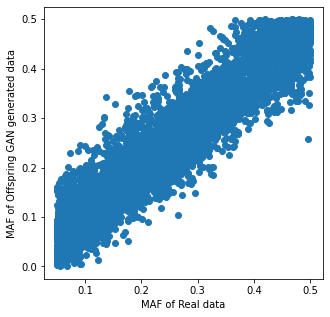

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter (x = MAF_R, y = MAF_OGAN )
plt.xlabel("MAF of Real data")
plt.ylabel("MAF of Offspring GAN generated data")
plt.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Histogram(
    x=MAF_R,
    histnorm='',
    name='Real Data', # name used in legend and hover labels
    xbins=dict( # bins used for histogram
        start=0.1,
        end=0.5,
        size=0.1
    ),
    marker_color='#79c09a',
    opacity=1
))
fig.add_trace(go.Histogram(
    x=MAF_OGAN,
    histnorm='',
    name='Offspring GAN Synthetic data',
    xbins=dict(
        start=0.1,
        end=0.5,
        size=0.1
    ),
    marker_color='#756fa3',
    opacity=1
))

fig.update_layout(
    # title_text='', # title of plot
    yaxis_title_text='Number of SNP Loci', # xaxis label
    xaxis_title_text='MAF value', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
# fig.update_layout(plot_bgcolor="#ffffff")
fig.update_xaxes(automargin=False)
fig.update_xaxes(dtick=0.1)
# fig.update_xaxes(rangebreaks=[{"values":(0.0,0.5)}])
# fig.update_xaxes(rangemode="tozero")

fig.show()
fig.write_html('/content/drive/MyDrive/X_Shi_Lab/SemX/SAGAN1/SyntheticData/m0t6c12/MAF_comp.html')

# GMM

GMM models are memory intensive and google collab runtime craches frequently, hence the same is performed in HPC.

In [ ]:
# X_train = np.load("/Data_HLA/X_train.npy")
X = X_train
X = np.argmax(X, axis=-1)
gm_RR = GaussianMixture(n_components=2, random_state=0).fit(X)

In [ ]:
# SynDss_SAGAN1_m0t6c12 = np.load("SynDss_SAGAN1_m0t6c12.npy")
SynXss_SAGAN1_m0t6c12 = SynDss_SAGAN1_m0t6c12[:,0:-1]
SynXss_SAGAN1_m0t6c12 = to_categorical(SynXss_SAGAN1_m0t6c12)
SynYss_SAGAN1_m0t6c12 = SynDss_SAGAN1_m0t6c12[:,-1].reshape((10028,1))
SynYss_SAGAN1_m0t6c12 = to_categorical(SynYss_SAGAN1_m0t6c12)
X = SynXss_SAGAN1_m0t6c12
X = np.argmax(X, axis=-1)
gm_SS_1 = GaussianMixture(n_components=2, random_state=0).fit(X)

In [ ]:
# SynDss_PPO_m0t1c34 = np.load("PPO/SyntheticData/m0t1c34/SynDss_PPO_m0t1c34.npy")
SynXss_PPO_m0t1c34 = SynDss_PPO_m0t1c34[:,0:-1]
SynXss_PPO_m0t1c34 = to_categorical(SynXss_PPO_m0t1c34)
SynYss_PPO_m0t1c34 = SynDss_PPO_m0t1c34[:,-1].reshape((12500,1))
SynYss_PPO_m0t1c34 = to_categorical(SynYss_PPO_m0t1c34)
X = SynXss_PPO_m0t1c34
X = np.argmax(X, axis=-1)
gm_SS_2 = GaussianMixture(n_components=2, random_state=0).fit(X)

In [ ]:
X = SynX_PGcB_m0t1c34
gm_CC = GaussianMixture(n_components=2, random_state=0).fit(X)

Compare the components with similar mean, we will call the component with higher mean as component 1, and the component with lower mean as component 2 for all 4 data distribution. Depending on that you need to be careful about which component is compared with which one. 